<a href="https://colab.research.google.com/github/gomes-lab/course-cs2770-2024sp/blob/main/Notebooks/sudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sudoku Solver in AMPL

In class, we saw two formulations of integer programs that could be used to complete a Latin square. Solving a sudoku puzzle is similar to completing a Latin square, where in addition to constraints fixing the provided values and specifying each digit appears once per row and column, we need to ensure each digit appears once per 3 x 3 square.

In this notebook we will implement a sudoku solver in AMPL by modifying the assignment formulation for Latin square completion shown in class.

In [1]:
"""
Task: Run this cell
"""
# Install AMPL dependencies
!pip install -q amplpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.0 MB/s eta 0:00:00


In [2]:
"""
Task: Run this cell
"""
# Import packages and setup AMPL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
from io import BytesIO

from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["highs"],      # modules to install
    license_uuid="default", # license to use
    g=globals())            # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [21]:
"""
Task: Run this cell
"""
# Load a dataset of 100 sudoku puzzles and their solutions
r = requests.get('https://github.com/gomes-lab/course-cs2770-2024sp/blob/main/data/sudokus.npy?raw=true', stream = True)
sudokus = np.load(BytesIO(r.raw.read()))

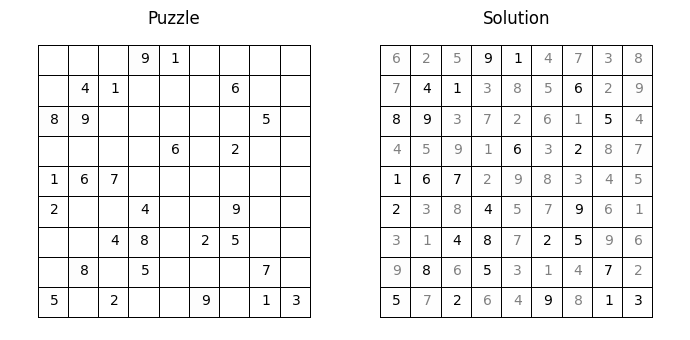

In [17]:
"""
Task: Run this cell. You can change the idx value to consider a different puzzle.
"""
# Visualize a single puzzle and its solution
idx = 15 ### Change this number to an integer from 0-99 to see another puzzle ###
puzzle = sudokus[idx]
fig = plt.figure(figsize=(7,3.5))
# Plot both the puzzle and its solution
for p in range(2):
  plt.subplot(1,2,p+1)
  plt.axis('off')
  plt.axis('equal')
  # Create the grid
  plt.pcolormesh(puzzle[p], edgecolors='k', linewidth=0.5, cmap='binary', vmax=1000)
  plt.title('Puzzle' if p == 0 else 'Solution')

  # Label the cells
  for i in range(9):
    for j in range(9):
      v = int(puzzle[p][i,j])
      col = 'black' if puzzle[0][i,j] > 0 else 'grey'
      plt.text(j + 0.4,i + 0.4, v if v != 0 else '', color=col)

plt.tight_layout()
plt.show()

Below is a partially completed implementation of the assignment formulation.

**Question:** Using the provided constraints to only allow one of each digit per column as an example, implement the constraints that each digit can occur at most once per row. Include the expression for your constraints in your write-up.

**Question:** Again, using the provided constraints to only allow one of each digit per column as an example, implement the constraints that each cell can only have one digit. Include the expression for your constraints in your write-up.

To help you with these questions, here is more explanation of the code:
*   `set Row := {1..9};` declares a set with values from 1 to 9 corresponding to the rows that will allow us to index rows efficiently. Sets are also declared for columns and digits.
*   `var X {Row, Col, Digit} binary;` defines our binary decision variables where for example `X[3,1,8] = 1` would indicate that the first cell of the third row contains an 8
*  `param S {Row, Col};` are helper constatns used set the provided values from the original puzzle
* `maximize Cells_Filled: sum {i in Row, j in Col, k in Digit} X[i,j,k];` encodes the objective, where we are maximizing the sum of binary decision variables. Because of the constraints, the objective will always be 81 for solved puzzles, corresponding to one digit being selected for each cell.
* `subject to Col_Consts {j in Col, k in Digit}: sum {i in Row} X[i,j,k] = 1;` encodes that each digit occurs once per column where `{j in Col, k in Digit}` means that 81 constraints are created by this statement with one constraint for each column-digit combination and `sum {i in Row} X[i,j,k] = 1` says to sum over all row values for column `i` and check exactly one variable is 1, indiciating exactly one cell has digit `k`. The questions above can be solved by making variations of this line to create constraints for the right combination of digits, cells, and rows and summing over the remaining values.
* `subject to Square_Consts {I in 0..2, J in 0..2, k in Digit}: sum {i in 1..3, j in 1..3} X[3*I + i, 3*J + j, k] = 1;` captures the square constraints. The idea is similar to the column constraints but requires more complex indexing to capture the squares
* `subject to Fixed_Values {i in Row, j in Col : S[i,j] > 0}: X[i,j, S[i,j]] = 1;` ensures that any values that are provided in the initial puzzle are respected by the solution, where the `S` matrix is defined in the next code block.

In [5]:
# Partially completed integer program to solve a sudoku puzzle
%%ampl_eval
reset;
set Row := {1..9};
set Col := {1..9};
set Digit := {1..9};

# Define variables and constants
var X {Row, Col, Digit} binary;
param S {Row, Col};

# Objective
maximize Cells_Filled: sum {i in Row, j in Col, k in Digit} X[i,j,k];

# Constraints so each digit appears once per column
subject to Col_Consts {j in Col, k in Digit}: sum {i in Row} X[i,j,k] = 1;

# Constraints so each digit appears once per row
# TODO

# Constaints so each cell has exactly one digit
# TODO

# 3 x 3 Square Constraints
subject to Square_Consts {I in 0..2, J in 0..2, k in Digit}: sum {i in 1..3, j in 1..3} X[3*I + i, 3*J + j, k] = 1;

# Constraints to fix provided values
subject to Fixed_Values {i in Row, j in Col : S[i,j] > 0}: X[i,j, S[i,j]] = 1;

In [19]:
# Define the fixed values and solve
S = puzzle[0].astype(int).tolist()
ampl.param['S'] = {(i,j): S[i-1][j-1]
                  for i in range(1,10)
                  for j in range(1,10)}

ampl.option["solver"] = "highs"
ampl.option["highs_options"] = "outlev=0"
ampl.solve()

HiGHS 1.7.0:   tech:outlev = 0
HiGHS 1.7.0: optimal solution; objective 81
31 simplex iterations
1 branching nodes


Now we will visualize AMPL's solution, comparing it to the solution provided in the dataset. The sudokus provided all have unique solutions, so your solution should match exactly. The cells in the AMPL solution are colored green if they match the provided solution and red if they do not match.

**Question:** Run the model to solve the puzzle and insert an image of the solution in your write-up. How long does the model to solve the puzzle?

The dataset includes 100 puzzles. Feel free to change the value of ``idx`` in the fourth cell from 12 to another integer from 0-99 and rerun the notebook to solve a new puzzle.

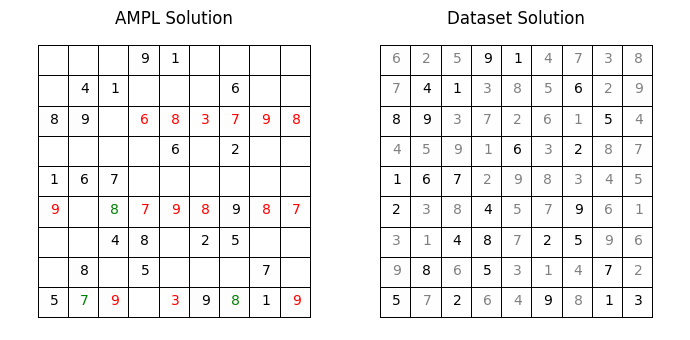

In [20]:
"""
Task: Run this and include an image of the solved puzzle in your write-up.
"""
# Extract the solution and plot the solution, comparing it to the solution provided
ampl_soln = ampl.get_data("X").to_dict()
soln = np.zeros((9,9))
for i in range(1,10):
  for j in range(1,10):
    for k in range(1,10):
      if ampl_soln[(i,j,k)] == 1:
        soln[i-1,j-1] = k

fig = plt.figure(figsize=(7,3.5))
# Plot both the AMPL solution and the solution from the dataset
for p in range(2):
  if p == 0:
    mat = soln
  else:
    mat = puzzle[1]
  plt.subplot(1,2,p+1)
  plt.axis('off')
  plt.axis('equal')
  # Create the grid
  plt.pcolormesh(mat, edgecolors='k', linewidth=0.5, cmap='binary', vmax=1000)
  plt.title('AMPL Solution' if p == 0 else 'Dataset Solution')

  # Label the cells
  for i in range(9):
    for j in range(9):
      v = int(mat[i,j])
      col = 'black' if puzzle[0][i,j] > 0 else 'grey'
      if (p == 0) and (puzzle[0][i,j] == 0):
        col = 'green' if v == puzzle[1][i,j] else 'red'
      elif (p == 0) and (puzzle[0][i,j] != 0):
        col = 'black' if v == puzzle[1][i,j] else 'red'
      plt.text(j + 0.4,i + 0.4, v if v != 0 else '', color=col)

plt.tight_layout()
plt.show()
